In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
#read in all the words
words = open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
#build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset
block_size = 3 #context length: how many characters do we take to predict the next one?
def build_dataset(words):

    X,Y = [],[]
    for w in words:

        # print(w)
        context = [0]*block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context),'---->',itos[ix])
            context = context[1:]+[ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [2]:
# utility function we will use later when comparing manual gradients to pytorch gradients
def cmp(s,dt,t):
    ex = torch.all(dt==t.grad).item()
    app = torch.allclose(dt,t.grad)
    maxdiff = (dt-t.grad).abs().max().item()
    print(f'{s:15s} | exact:{str(ex):5s} | approximate:{str(app):5s |maxdiff:{maxdiff}}')

In [ ]:
#MLP revisited
n_embd = 10 #the dimensionality of the character embedding vectors
n_hidden = 200 #the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((vocab_size,n_embd),generator=g)
W1 = torch.randn((n_embd*block_size,n_hidden),generator=g)* (5/3)/((n_embd*block_size)**0.5)
b1 = torch.randn(n_hidden,generator=g)* 0.1
W2 = torch.randn((n_hidden,vocab_size),generator=g) * 0.1
b2 = torch.randn(vocab_size,generator=g) * 0.1

bngain = torch.ones(1,n_hidden)*0.1+1.0
bnbias = torch.zeros(1,n_hidden)*0.1
# bnmean_running = torch.zeros((1,n_hidden))
# bnstd_running = torch.ones((1,n_hidden))

#Note:I am initializating many of these parameters in non-standard ways
#because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C,W1,W2,b1,b2,bngain,bnbias]

print(sum(p.nelement() for p in parameters))  #number of parameters in float
for p in parameters:
    p.requires_grad = True
    

12097


In [ ]:
batch_size = 32
n = batch_size # a shorter variable also,for convenience
# construct a minibatch
ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
Xb,Yb = Xtr[ix],Ytr[ix] #batch X,Y


In [14]:
#same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix =  torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb = Xtr[ix],Ytr[ix]

    #forward pass
    emb = C[Xb] #[32,3,2] #embed the characters into vectors
    embcat = emb.view(emb.shape[0],-1) #concatenate the vectors
    # Linear layer
    hpreat = embcat @ W1 #+b1 #[32,100] #hidden layer pre-activatiion
    #BatchNorm layer
    #-------------------------------------------------------------------------------------------
    bnmeani = hpreat.mean(0,keepdim=True)
    bnstdi = hpreat.std(0,keepdim=True)
    hpreat = bngain * (hpreat- bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999*bnstd_running +  0.001 * bnstdi
    #-------------------------------------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreat) #hidden layer
    logits = h @ W2 + b2 #(32,27)   
    # counts = logits.exp()
    # prob = counts / counts.sum(1,keepdim=True)
    # loss = -prob[torch.arange(228146),Y].log().mean()
    loss = F.cross_entropy(logits,Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update 
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad

    #track stats
    # lri.append(lre[i])
    if i%10000 == 0: #print every once in a while
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000:3.3239
  10000/ 200000:2.0322
  20000/ 200000:2.5675
  30000/ 200000:2.0125
  40000/ 200000:2.2446
  50000/ 200000:1.8897
  60000/ 200000:2.0785
  70000/ 200000:2.3681
  80000/ 200000:2.2918
  90000/ 200000:2.0238
 100000/ 200000:2.3673
 110000/ 200000:2.3132
 120000/ 200000:1.6414
 130000/ 200000:1.9311
 140000/ 200000:2.2231
 150000/ 200000:2.0027
 160000/ 200000:2.0997
 170000/ 200000:2.4949
 180000/ 200000:2.0199
 190000/ 200000:2.1707


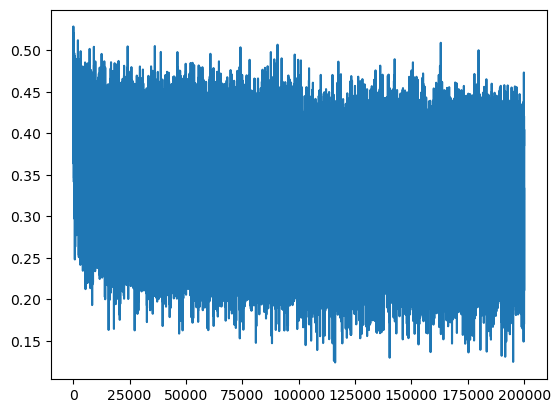

In [ ]:
plt.plot(lossi)

In [ ]:
@torch.no_grad() #this decorator disables gradient tracking
def split_loss(split):
    x,y={
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte)
    }[split]
    emb = C[x] #(N,block_size,n_embed)
    embcat = emb.view(emb.shape[0],-1)#concat into (N,block_size*n_embed)
    hpreat = embcat @ W1 #+b1 #[32,100] #hidden layer pre-activatiion
    hpreat = bngain * (hpreat- bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreat) #(N,n_hidden)
    logits = h @ W2 + b2 #(N,vocab_size)
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss('train')
split_loss('val')


train 2.066826820373535
val 2.104844808578491


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * block_size #initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]  #(1,block_size,n_embed)
        h = torch.tanh(emb.view(1,-1) @ W1+b1) #[32,100]
        logits = h @ W2 + b2 #(32,27)
        probs = F.softmax(logits,dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs,num_samples=1,replacement=True,generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special "." token,break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out)) #decode and print the generated word

jupsdedianasadha.
stayleigh.
fuhasthmysonstyett.
sasgadus.
bdaeviasshbynishwi.
brissiyanaylanthrissaumrkyffetumj.
prynslegh.
sanqucfslaysengcarristan.
blaimiissaynishan.
ssn.
saffurnszahddson.
blaynailissaphlamshmy.
jasruli.
lah.
fysi.
bjukumitzivuswitte.
mackramriyah.
jaszita.
balvishal.
bruibhav.


In [ ]:
# summary------------------------

In [46]:
# Let's train a deeper network

class Linear:

    def __init__(self,fan_in,fan_out,bias=True):
        self.weight = torch.randn((fan_in,fan_out),generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self,x):
        self.out = x@self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self,dim,eps=1e-5,momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers(trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self,x):
        # caculate the forward pass
        if self.training:
            xmean = x.mean(0,keepdim=True) #batch mean
            xvar = x.var(0,keepdim=True,unbiased=True) #batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar+self.eps) #normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum) * self.running_mean + self.momentum*xmean
                self.running_var = (1-self.momentum) * self.running_var + self.momentum*xvar
            return self.out
        
    def parameters(self):
        return [self.gamma,self.beta]
    
class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []


n_embd = 10 #the dimensionality of the character embedding  vectors
n_hidden = 100 #the number of neurons in the hidden layer of the mlp
g = torch.Generator().manual_seed(2147483647) #for reproducibility

C = torch.randn((vocab_size,n_embd),generator=g)

layers = [
    Linear(n_embd*block_size,n_hidden),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,n_hidden),BatchNorm1d(n_hidden),Tanh(),
    Linear(n_hidden,vocab_size),BatchNorm1d(vocab_size),

]

with torch.no_grad():
    #last layer:make less confident
    # layers[-1].weight *= 0.1
    layers[-1].gamma *= 0.1
    # all other layers:apply gain
    for layer in layers[:-1]:
        if isinstance(layer,Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47551


In [47]:
#same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix =  torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb = Xtr[ix],Ytr[ix]

    #forward pass
    emb = C[Xb] #[32,3,2] #embed the characters into vectors
    x = emb.view(emb.shape[0],-1) #concatenate the vectors
    # Linear layer batchNorm
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x,Yb)
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad() #AFTER_DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update 
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad


    #track stats
    # lri.append(lre[i])
    if i%10000 == 0: #print every once in a while
        print(f'{i:7d}/{max_steps:7d}:{loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std()/p.data.std()).log10().item() for p in parameters])
    
    if i>=1000:
        break #AFTER_DEBUG: would take out obviously to run full optimization


      0/ 200000:3.2870


layer 2 (      Tanh): mean +00,std 0.63,saturated: 2.62%
layer 5 (      Tanh): mean +00,std 0.64,saturated: 2.47%
layer 8 (      Tanh): mean +00,std 0.64,saturated: 2.16%
layer 11 (      Tanh): mean +00,std 0.65,saturated: 1.81%
layer 14 (      Tanh): mean +00,std 0.65,saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

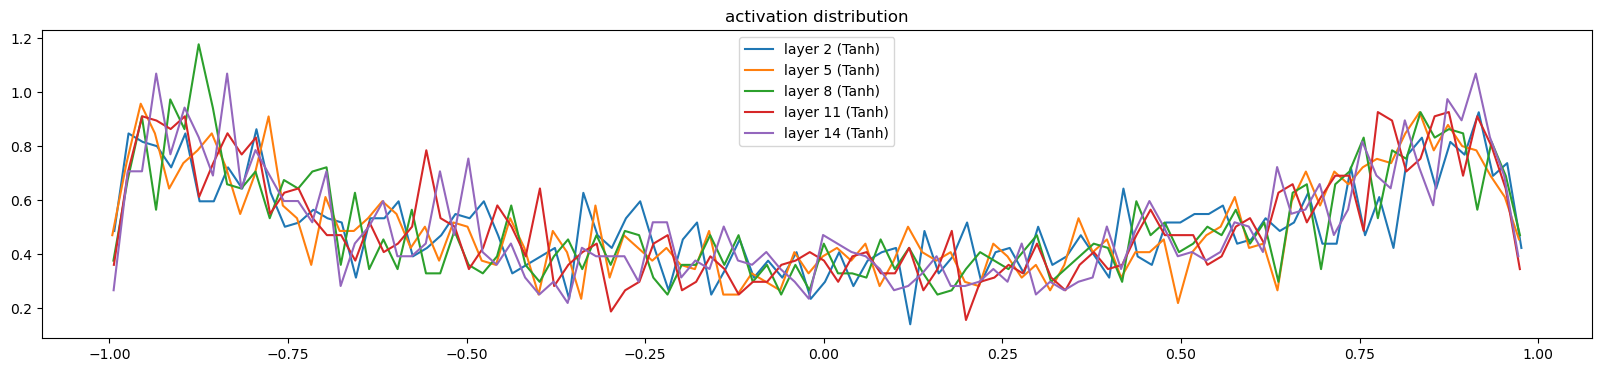

In [48]:
# visualize histograms
plt.figure(figsize=(20,4)) #width and height of the plot
legends = []
for i ,layer in enumerate(layers[:-1]): #note:exclude the output layer
    if isinstance(layer,Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2d,std %.2f,saturated: %.2f%%' %(i,layer.__class__.__name__,t.mean(),t.std(),(t.abs()>0.97).float().mean()*100))
        hy,hx = torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000,std 3.682956e-03
layer 5 (      Tanh): mean +0.000000,std 3.262610e-03
layer 8 (      Tanh): mean +0.000000,std 2.973730e-03
layer 11 (      Tanh): mean -0.000000,std 2.741111e-03
layer 14 (      Tanh): mean +0.000000,std 2.584294e-03


Text(0.5, 1.0, 'grad distribution')

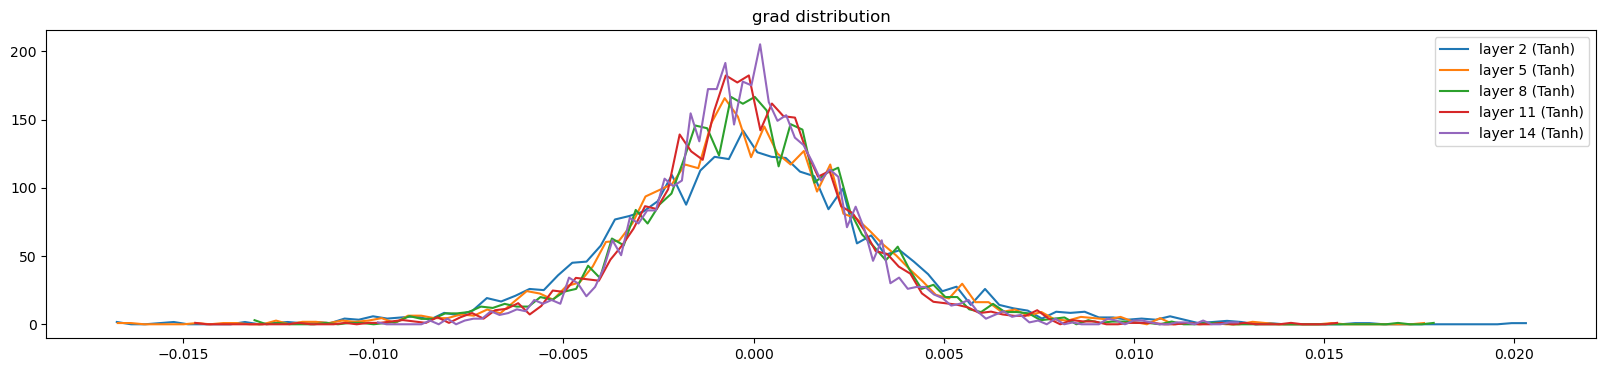

In [49]:
# visualize histograms
plt.figure(figsize=(20,4)) #width and height of the plot
legends = []
for i ,layer in enumerate(layers[:-1]): #note:exclude the output layer
    if isinstance(layer,Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f,std %e' %(i,layer.__class__.__name__,t.mean(),t.std()))
        hy,hx = torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('grad distribution')

weight   (27, 10) | mean -0.000000,std 1.019887e-02 | grad:data ratio 1.018848e-02
weight  (30, 100) | mean +0.000092,std 8.238435e-03 | grad:data ratio 2.635841e-02
weight (100, 100) | mean +0.000031,std 7.318117e-03 | grad:data ratio 4.377147e-02
weight (100, 100) | mean -0.000019,std 6.662026e-03 | grad:data ratio 3.949897e-02
weight (100, 100) | mean -0.000019,std 5.821517e-03 | grad:data ratio 3.468161e-02
weight (100, 100) | mean +0.000053,std 5.445298e-03 | grad:data ratio 3.243368e-02
weight  (100, 27) | mean -0.000165,std 1.046845e-02 | grad:data ratio 6.281267e-02


Text(0.5, 1.0, 'weights gradient distribution')

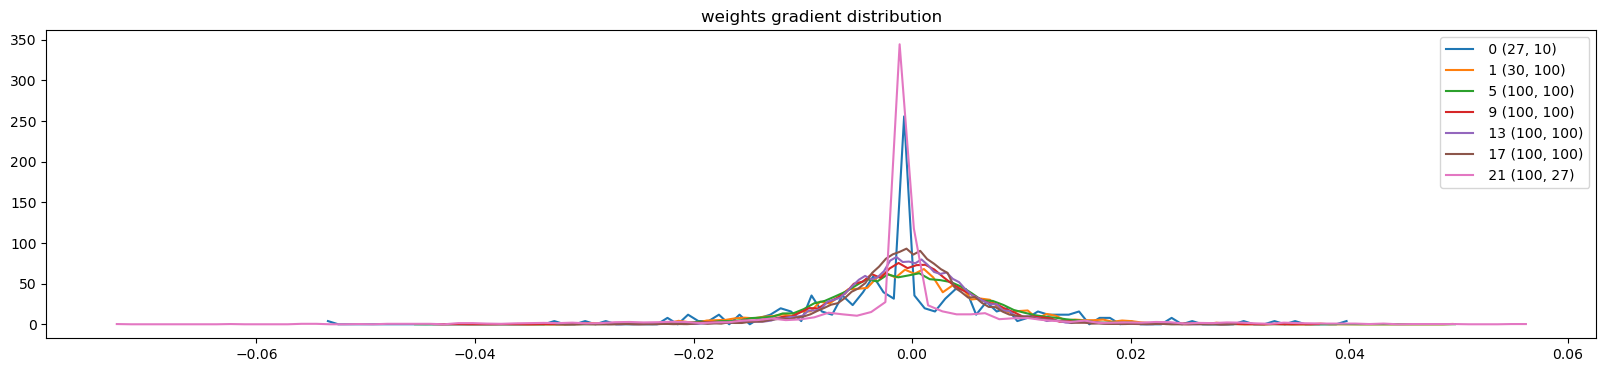

In [50]:
# visualize histograms
plt.figure(figsize=(20,4)) #width and height of the plot
legends = []
for i ,p in enumerate(parameters): #note:exclude the output layer
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f,std %e | grad:data ratio %e' %(tuple(p.shape),t.mean(),t.std(),t.std()/p.std()))
        hy,hx = torch.histogram(t,density=True)
        plt.plot(hx[:-1].detach(),hy.detach())
        legends.append(f' {i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('weights gradient distribution')

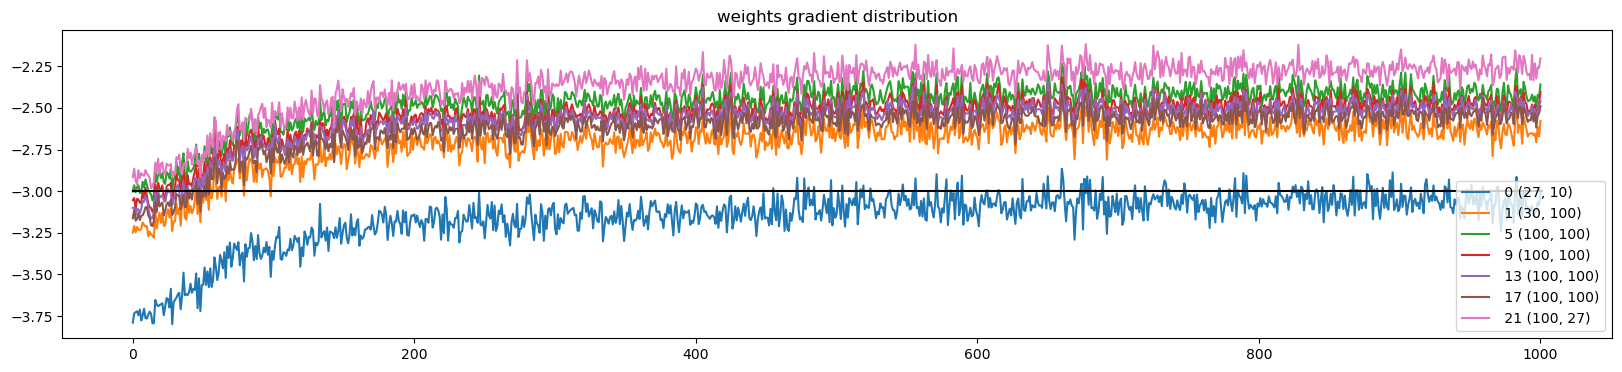

In [51]:
# visualize histograms
plt.figure(figsize=(20,4)) #width and height of the plot
legends = []
for i ,p in enumerate(parameters): #note:exclude the output layer
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        
        legends.append(f' {i} {tuple(p.shape)}')
plt.plot([0,len(ud)],[-3,-3],'k') #these ratios should be ~le-3,indicate on plot
plt.title('weights gradient distribution')
plt.legend(legends);
